In [1]:
import sys, os 
package_path = os.path.dirname(os.path.dirname(os.getcwd())) 
print(f'{package_path=}')
sys.path.insert(0, package_path)

import xarray as xr 
import pandas as pd
import numpy as np
import os 
from glob import glob
from datetime import datetime

from wofscast.common.plot_utils import WoFSLevels, WoFSColors
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors
# To display the animation in a Jupyter notebook
from IPython.display import HTML

package_path='/home/monte.flora/python_packages/frdd-wofs-cast'


In [2]:
base_path = '/work2/wof/SummaryFiles'
case_date = '20230523_d1'
init_time = '0000'

paths = glob(os.path.join(base_path, case_date, init_time, 'wofs_ALL*.nc'))
paths.sort() 

paths = paths[:36]

In [3]:
def convert_valid_time(valid_time_str):
    dt_str = datetime.strptime(valid_time_str, '%Y%m%d_%H%M%S').strftime('%Y-%m-%d %H:%M:%S')
    return pd.Timestamp(dt_str)

CPU times: user 8.47 s, sys: 150 ms, total: 8.62 s
Wall time: 14.3 s


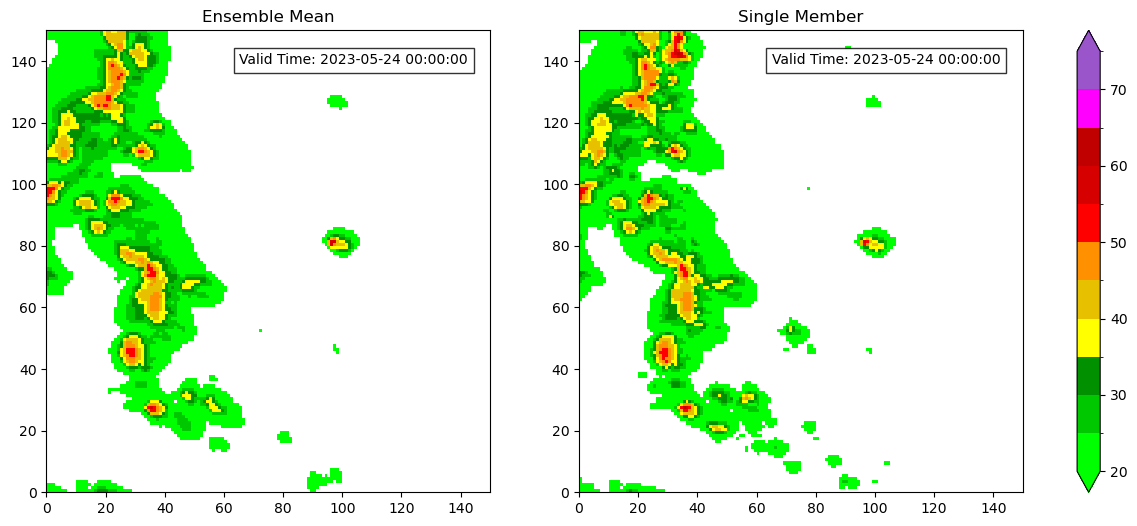

In [5]:
%%time

fig, axes = plt.subplots(dpi=100, figsize=(14,6), ncols=2)

cmap = WoFSColors.nws_dz_cmap
levels = WoFSLevels.dz_levels_nws
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# Initialize the dataset
ds = xr.open_dataset(paths[0], chunks={})
comp_dz = ds['comp_dz'].isel(lat=slice(75, 225), lon=slice(75, 225)).compute()
mean_comp_dz = comp_dz.mean(dim='ne')  # Calculate the ensemble mean
ds.close()

# Mask values below a threshold
mean_comp_dz = np.ma.masked_where(mean_comp_dz < 5, mean_comp_dz)
single_member_comp_dz = np.ma.masked_where(comp_dz[0] < 5, comp_dz[0])

# Initialize pcolormesh for ensemble mean and a single member
mesh1 = axes[0].pcolormesh(mean_comp_dz, cmap=cmap, norm=norm)
mesh2 = axes[1].pcolormesh(single_member_comp_dz, cmap=cmap, norm=norm)

# Add a single colorbar that spans both subplots
cbar = fig.colorbar(mesh1, ax=axes, boundaries=levels, extend='both', location='right', fraction=0.05, pad=0.05)

# Set titles for each subplot
axes[0].set_title("Ensemble Mean")
axes[1].set_title("Single Member")

def update(t):
    # Clear the axes
    for ax in axes:
        ax.clear()

    ds = xr.open_dataset(paths[t], chunks={})
    comp_dz = ds['comp_dz'].isel(lat=slice(75, 225), lon=slice(75, 225)).compute()
    valid_time = convert_valid_time(ds.valid_time)  # Convert valid_time
    
    ds.close()

    mean_comp_dz = np.ma.masked_where(comp_dz.mean(dim='ne') < 5, comp_dz.mean(dim='ne'))
    single_member_comp_dz = np.ma.masked_where(comp_dz[0] < 5, comp_dz[0])

    # Update pcolormesh for ensemble mean and single member
    mesh1 = axes[0].pcolormesh(mean_comp_dz, cmap=cmap, norm=norm)
    mesh2 = axes[1].pcolormesh(single_member_comp_dz, cmap=cmap, norm=norm)
    
    # Annotate the valid time in the top-right corner of both subplots
    for ax in axes:
        ax.text(0.95, 0.95, f"Valid Time: {valid_time}", 
                horizontalalignment='right', verticalalignment='top', 
                transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    # Set titles for each subplot
    axes[0].set_title("Ensemble Mean")
    axes[1].set_title("Single Member")

# Create the animation
n_frames = len(paths)
anim = FuncAnimation(fig, update, frames=n_frames)

HTML(anim.to_jshtml())

#Optionally, to save the animation
#anim.save(f"gifs/mean_vs_single_mem_comp_dz.gif", 
#              writer="pillow", fps=3)

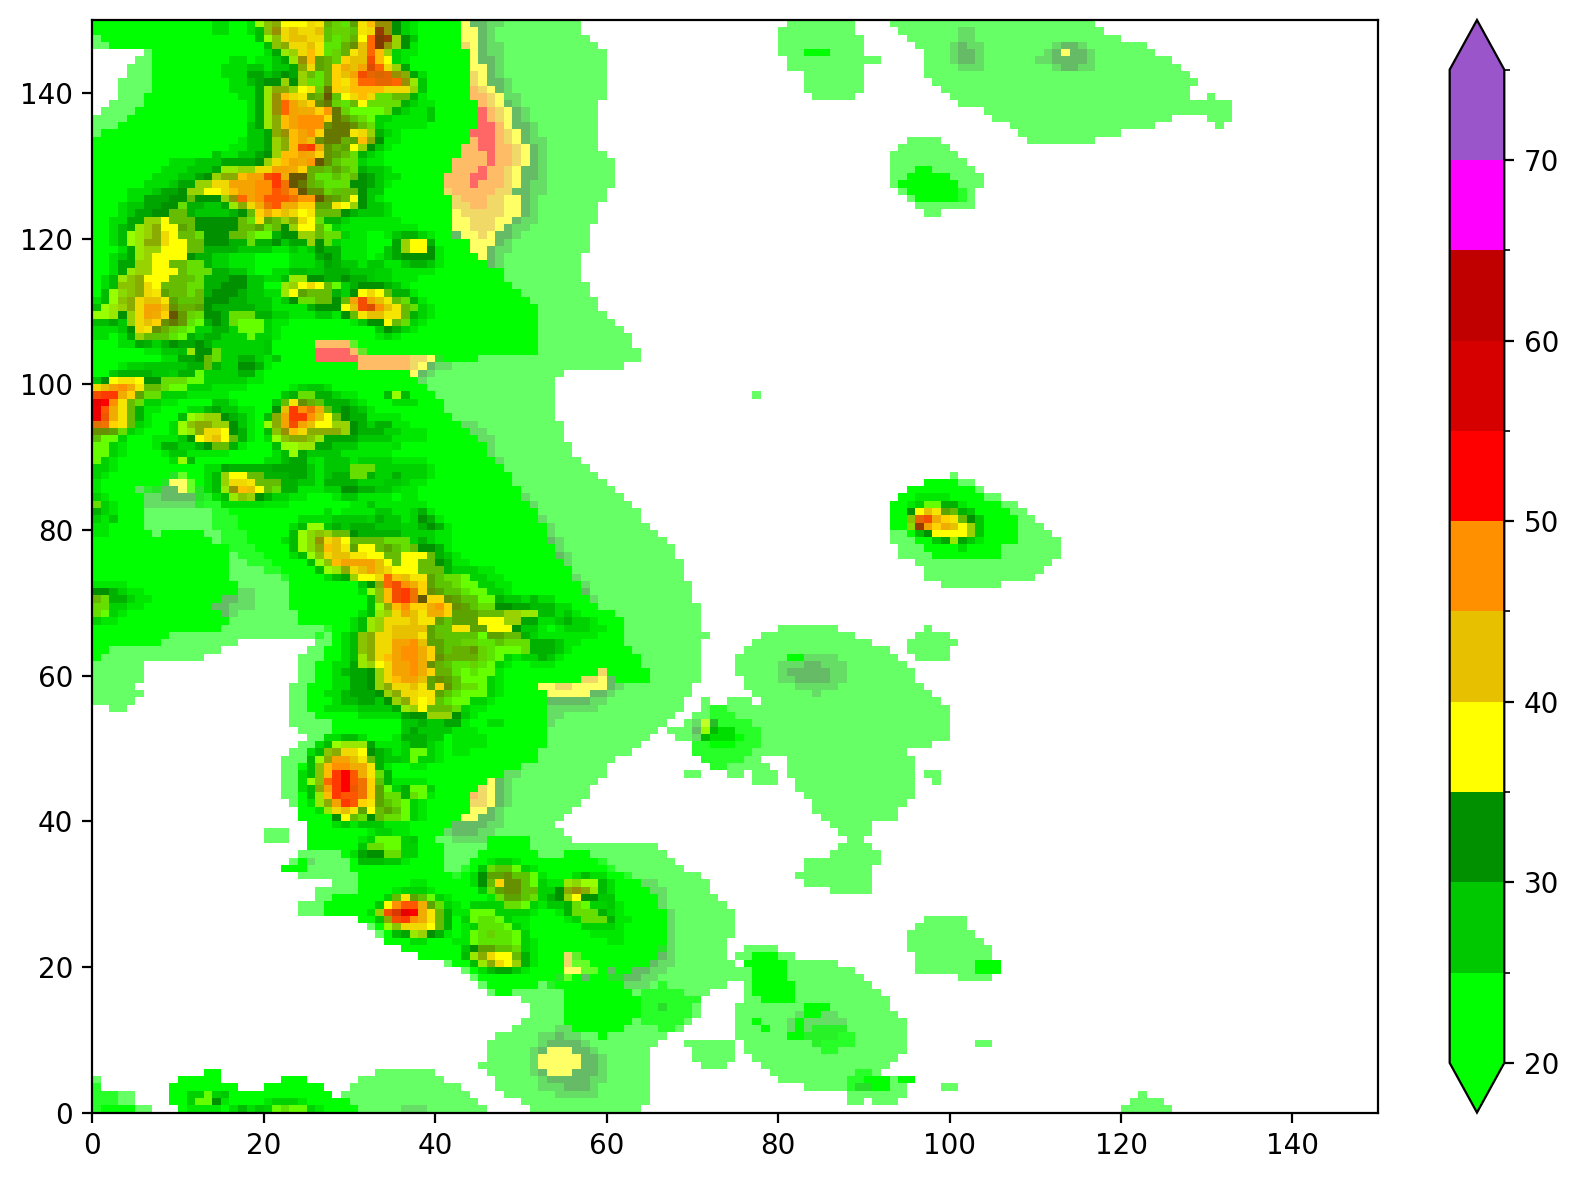

In [14]:
# Define the colormap and normalization
cmap = WoFSColors.nws_dz_cmap
levels = WoFSLevels.dz_levels_nws
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# Load the datasets
ds_ic = xr.open_dataset(paths[0], chunks={})  # Initial condition (single member)
ds_10min = xr.open_dataset(paths[2], chunks={})  # 10-minute forecast
ds_60min = xr.open_dataset(paths[12], chunks={})  # 60-minute forecast

# Slice and compute the comp_dz for each dataset
comp_dz_ic = ds_ic['comp_dz'].isel(lat=slice(75, 225), lon=slice(75, 225)).compute()
comp_dz_10min = ds_10min['comp_dz'].isel(lat=slice(75, 225), lon=slice(75, 225)).compute()
comp_dz_60min = ds_60min['comp_dz'].isel(lat=slice(75, 225), lon=slice(75, 225)).compute()

# Calculate the ensemble mean for 10-min and 60-min datasets
mean_comp_dz_10min = comp_dz_10min.mean(dim='ne')
mean_comp_dz_60min = comp_dz_60min.mean(dim='ne')

# Mask values below a threshold
single_member_comp_dz_ic = np.ma.masked_where(comp_dz_ic[0] < 5, comp_dz_ic[0])
mean_comp_dz_10min = np.ma.masked_where(mean_comp_dz_10min < 5, mean_comp_dz_10min)
mean_comp_dz_60min = np.ma.masked_where(mean_comp_dz_60min < 5, mean_comp_dz_60min)

# Close datasets to free up resources
ds_ic.close()
ds_10min.close()
ds_60min.close()

fig, ax = plt.subplots(dpi=200, figsize=(8,6))

# Plot the single member from ds_ic with lower alpha
ax.pcolormesh(single_member_comp_dz_ic, cmap=cmap, norm=norm, alpha=0.6, zorder=2)

# Plot the ensemble mean from ds_10min
mesh_10min = ax.pcolormesh(mean_comp_dz_10min, cmap=cmap, norm=norm, zorder=1)

# Plot the ensemble mean from ds_60min
ax.pcolormesh(mean_comp_dz_60min, cmap=cmap, norm=norm, alpha=0.6, zorder=0)

# Add a single colorbar for all subplots
cbar = fig.colorbar(mesh_10min, ax=ax, 
                    boundaries=levels, extend='both', location='right', fraction=0.05, pad=0.05)

plt.tight_layout()

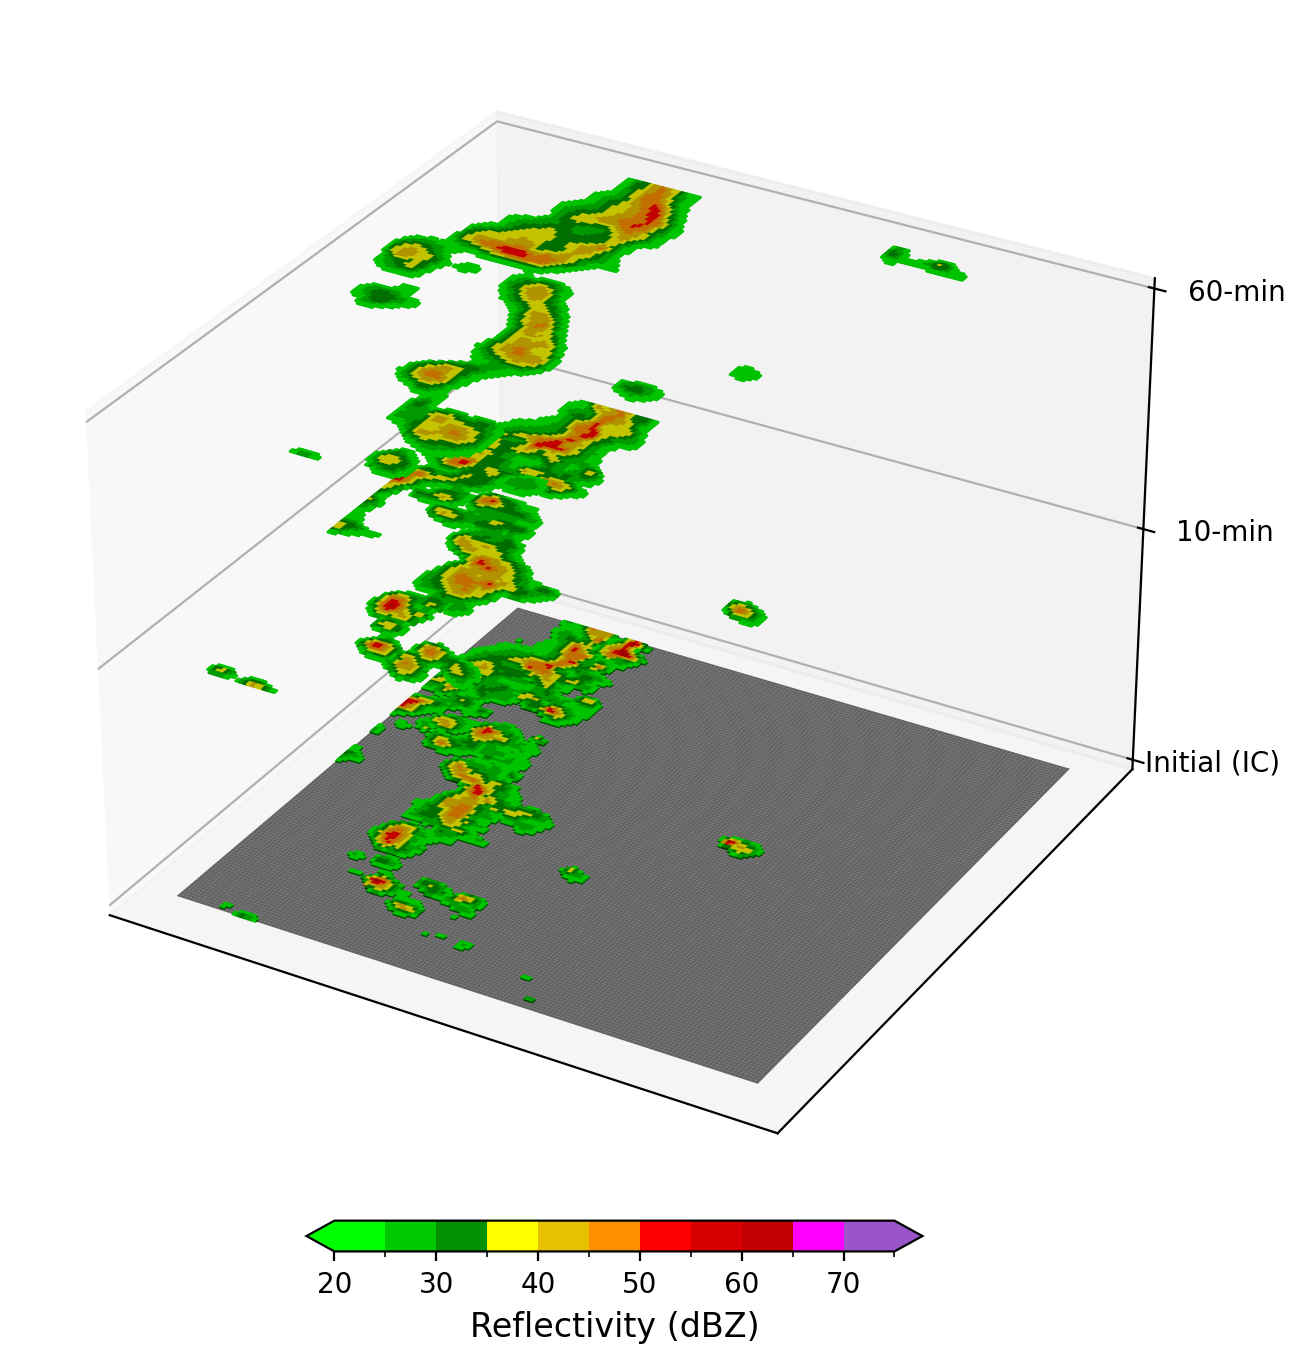

In [31]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D

# Define the colormap and normalization
cmap = WoFSColors.nws_dz_cmap
levels = WoFSLevels.dz_levels_nws
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

min_dbz = 20

# Load the datasets
ds_ic = xr.open_dataset(paths[0], chunks={})  # Initial condition (single member)
ds_10min = xr.open_dataset(paths[2], chunks={})  # 10-minute forecast
ds_60min = xr.open_dataset(paths[12], chunks={})  # 60-minute forecast

# Slice and compute the comp_dz for each dataset
comp_dz_ic = ds_ic['comp_dz'].isel(lat=slice(75, 225), lon=slice(75, 225)).compute()
comp_dz_10min = ds_10min['comp_dz'].isel(lat=slice(75, 225), lon=slice(75, 225)).compute()
comp_dz_60min = ds_60min['comp_dz'].isel(lat=slice(75, 225), lon=slice(75, 225)).compute()

# Calculate the ensemble mean for 10-min and 60-min datasets
mean_comp_dz_10min = comp_dz_10min.mean(dim='ne')
mean_comp_dz_60min = comp_dz_60min.mean(dim='ne')

# Mask values below a threshold
single_member_comp_dz_ic = np.ma.masked_where(comp_dz_ic[0] < min_dbz, comp_dz_ic[0])
mean_comp_dz_10min = np.ma.masked_where(mean_comp_dz_10min < min_dbz, mean_comp_dz_10min)
mean_comp_dz_60min = np.ma.masked_where(mean_comp_dz_60min < min_dbz, mean_comp_dz_60min)

lon, lat = np.meshgrid(np.arange(150), np.arange(150))

# Close datasets to free up resources
ds_ic.close()
ds_10min.close()
ds_60min.close()

# Create 3D figure
fig = plt.figure(dpi=200, figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Plot the initial condition (single member) at z=0
ax.plot_surface(lon, lat, np.zeros_like(lon), facecolors=cmap(norm(single_member_comp_dz_ic)), 
                rstride=1, cstride=1, shade=True, alpha=0.6)

# Plot the 10-min ensemble mean at z=1
ax.plot_surface(lon, lat, np.ones_like(lon), facecolors=cmap(norm(mean_comp_dz_10min)), 
                rstride=1, cstride=1, shade=True)

# Plot the 60-min ensemble mean at z=2
ax.plot_surface(lon, lat, np.ones_like(lon) * 2, facecolors=cmap(norm(mean_comp_dz_60min)), 
                rstride=1, cstride=1, shade=True)

# Set axis labels
#ax.set_xlabel('Longitude')
#ax.set_ylabel('Latitude')
#ax.set_zlabel('Time Step')


# Set ticks and grid for z-axis to represent time steps
ax.set_xticks([])
ax.set_yticks([])

ax.set_zticks([0, 1, 2])
ax.set_zticklabels(['Initial (IC)', '10-min', '60-min'])
ax.tick_params(axis='z', pad=10) 

# Add a colorbar for the data
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array([])  # Required for the colorbar
cbar = fig.colorbar(mappable, ax=ax, boundaries=levels, extend='both', 
             fraction=0.025, pad=0.01, orientation='horizontal')

# Add a label to the colorbar
cbar.set_label('Reflectivity (dBZ)', fontsize=12)  # Customize the label text and fontsize as needed